In [ ]:
from pandas import read_csv
import pandas as pd

# Specify the encoding as detected ('ascii')
train_data = pd.read_csv('/content/srsstat_train_data.csv', encoding='ascii')  # Updated encoding to 'ascii'

test_data = pd.read_csv('/content/srsstat_test_data.csv', encoding='ascii')  # Updated encoding to 'ascii'

In [ ]:
train_data.value_counts('cluster')

,count
cluster,
1,7202
0,6913
2,6885


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 87 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                21000 non-null  int64  
 1   age                        21000 non-null  int64  
 2   gender                     21000 non-null  object 
 3   income_bracket             21000 non-null  object 
 4   loyalty_program            21000 non-null  object 
 5   membership_years           21000 non-null  int64  
 6   churned                    21000 non-null  object 
 7   marital_status             21000 non-null  object 
 8   number_of_children         21000 non-null  int64  
 9   education_level            21000 non-null  object 
 10  occupation                 21000 non-null  object 
 11  transaction_id             21000 non-null  int64  
 12  product_id                 21000 non-null  int64  
 13  product_category           21000 non-null  obj

# Regular

## Random Forest - Without Balancing - All Features

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from collections import Counter

# Verify train_data and test_data exist from previous steps
if 'train_data' not in globals() or 'test_data' not in globals():
    raise ValueError("train_data or test_data not found! Ensure previous steps are executed.")

# Define the attributes
selected_features = [
    # Categorical attributes
    'last_purchase_month', 'promotion_end_month', 'product_manufacture_month',
    'month_of_year', 'product_expiry_date_year', 'product_manufacture_year',
    'transaction_year', 'product_expiry_date_month', 'transaction_month',
    'high_value_purchase', 'week_of_year', 'promotion_start_month', 'day_of_week',
    'purchase_frequency', 'customer_city', 'gender', 'weekend', 'store_state',
    'email_subscriptions', 'store_location', 'high_value_quantity',
    # Numeric attributes
    'customer_support_calls', 'product_review_count', 'days_since_last_purchase',
    'online_purchases', 'distance_to_store', 'product_rating', 'total_transactions',
    'product_weight', 'total_items_purchased', 'unit_price', 'total_returned_value',
    'membership_years', 'discount_applied', 'avg_discount_used', 'product_shelf_life',
    'total_returned_items', 'transaction_hour', 'min_single_purchase_value',
    'number_of_children', 'product_stock', 'avg_purchase_value',
    'avg_items_per_transaction', 'website_visits', 'age', 'max_single_purchase_value',
    'avg_spent_per_category', 'total_discounts_received', 'product_return_rate',
    'avg_transaction_value', 'in_store_purchases'
]
# Filter features that exist in train_data
selected_features = [col for col in selected_features if col in train_data.columns]
print("Selected features for Random Forest:", selected_features)

# Define features (X) and target (y) for train and test sets
X_train = train_data[selected_features]
y_train = train_data['cluster']
X_test = test_data[selected_features]
y_test = test_data['cluster']

# Print class distribution in training set
print("Class Distribution in Training Set:", Counter(y_train))

# Identify categorical and numeric columns among selected features
categorical_cols = [col for col in selected_features if col in ['last_purchase_month', 'promotion_end_month', 'product_manufacture_month', 'month_of_year', 'product_expiry_date_year',
                                                                'product_manufacture_year', 'transaction_year', 'product_expiry_date_month', 'transaction_month', 'high_value_purchase',
                                                                'week_of_year', 'promotion_start_month', 'day_of_week', 'purchase_frequency', 'customer_city', 'gender', 'weekend', 'store_state',
                                                                'email_subscriptions', 'store_location', 'high_value_quantity']]
numeric_cols = [col for col in selected_features if col not in categorical_cols]

# Preprocessing pipeline for encoding and scaling
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols)
])

# Create pipeline with preprocessing and Random Forest
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train Random Forest with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predictions on test set
y_pred = best_model.predict(X_test)

# Get unique cluster labels for classification report
unique_clusters = sorted(y_train.unique())
target_names = [f'Cluster {i}' for i in unique_clusters]

# Classification Report and Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Accuracy, Recall, Precision
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate Specificity for each cluster
def calculate_specificity(class_idx):
    # True Negatives for the current class
    tn = cm.sum() - cm[:, class_idx].sum() - cm[class_idx, :].sum() + cm[class_idx, class_idx]
    # False Positives for the current class
    fp = cm[:, class_idx].sum() - cm[class_idx, class_idx]
    # Specificity = TN / (TN + FP)
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Calculate specificity for each cluster
specificity_scores = {f'Cluster {i}': calculate_specificity(idx) for idx, i in enumerate(unique_clusters)}

# Print metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
for cluster, spec in specificity_scores.items():
    print(f"Specificity for {cluster}: {spec:.4f}")

print("-----------------------------------------------")

# --- Cross-Validation on Full Dataset ---
# Combine train and test data for cross-validation
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

# Perform 5-fold cross-validation using the best model
cv_scores = cross_val_score(best_model, X_full, y_full, cv=5, scoring='accuracy', n_jobs=-1)
print(f"\nCross-Validation Results (5-fold):")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print(f"Individual Fold Scores: {cv_scores}")


Selected features for Random Forest: ['last_purchase_month', 'promotion_end_month', 'product_manufacture_month', 'month_of_year', 'product_expiry_date_year', 'product_manufacture_year', 'transaction_year', 'product_expiry_date_month', 'transaction_month', 'high_value_purchase', 'week_of_year', 'promotion_start_month', 'day_of_week', 'purchase_frequency', 'customer_city', 'gender', 'weekend', 'store_state', 'email_subscriptions', 'store_location', 'high_value_quantity', 'customer_support_calls', 'product_review_count', 'days_since_last_purchase', 'online_purchases', 'distance_to_store', 'product_rating', 'total_transactions', 'product_weight', 'total_items_purchased', 'unit_price', 'total_returned_value', 'membership_years', 'discount_applied', 'avg_discount_used', 'product_shelf_life', 'total_returned_items', 'transaction_hour', 'min_single_purchase_value', 'number_of_children', 'product_stock', 'avg_purchase_value', 'avg_items_per_transaction', 'website_visits', 'age', 'max_single_pur

## Random Forest - Without Balancing - Selected Features

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from collections import Counter
import pandas as pd
import numpy as np

# Verify train_data and test_data exist from previous steps
if 'train_data' not in globals() or 'test_data' not in globals():
    raise ValueError("train_data or test_data not found! Ensure previous steps are executed.")

# Define the attributes as specified
selected_features = [
    # Categorical attributes
    'last_purchase_month', 'promotion_end_month', 'product_manufacture_month',
    'month_of_year', 'product_expiry_date_year', 'product_manufacture_year',
    'transaction_year', 'product_expiry_date_month', 'transaction_month',
    'high_value_purchase', 'week_of_year', 'promotion_start_month', 'day_of_week',
    'purchase_frequency', 'customer_city', 'gender', 'weekend', 'store_state',
    'email_subscriptions', 'store_location', 'high_value_quantity',
    # Numeric attributes
    'customer_support_calls', 'product_review_count', 'days_since_last_purchase',
    'online_purchases', 'distance_to_store', 'product_rating', 'total_transactions',
    'product_weight', 'total_items_purchased', 'unit_price', 'total_returned_value',
    'membership_years', 'discount_applied', 'avg_discount_used', 'product_shelf_life',
    'total_returned_items', 'transaction_hour', 'min_single_purchase_value',
    'number_of_children', 'product_stock', 'avg_purchase_value',
    'avg_items_per_transaction', 'website_visits', 'age', 'max_single_purchase_value',
    'avg_spent_per_category', 'total_discounts_received', 'product_return_rate',
    'avg_transaction_value', 'in_store_purchases'
]

# Filter features that exist in train_data
selected_features = [col for col in selected_features if col in train_data.columns]
print("Initial selected features:", selected_features)

# Define features (X) and target (y) for train and test sets
X_train = train_data[selected_features]
y_train = train_data['cluster']
X_test = test_data[selected_features]
y_test = test_data['cluster']

# Print class distribution in training set
print("Class Distribution in Training Set:", Counter(y_train))

# Identify categorical and numeric columns among selected features
categorical_cols = [col for col in selected_features if col in ['last_purchase_month', 'promotion_end_month', 'product_manufacture_month', 'month_of_year', 'product_expiry_date_year',
                                                                'product_manufacture_year', 'transaction_year', 'product_expiry_date_month', 'transaction_month', 'high_value_purchase',
                                                                'week_of_year', 'promotion_start_month', 'day_of_week', 'purchase_frequency', 'customer_city', 'gender', 'weekend', 'store_state',
                                                                'email_subscriptions', 'store_location', 'high_value_quantity']]
numeric_cols = [col for col in selected_features if col not in categorical_cols]

# Preprocessing pipeline for encoding and scaling
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols)
])

# Preprocess the data before RFECV to handle categorical features
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Get transformed feature names
feature_names = preprocessor.get_feature_names_out()

# Initialize RFECV with a Random Forest base estimator
base_model = RandomForestClassifier(random_state=42, n_estimators=50)  # Reduced n_estimators for speed
rfecv = RFECV(estimator=base_model, step=1, cv=3, scoring='accuracy', n_jobs=-1)
rfecv.fit(X_train_transformed, y_train)

# Get selected features from transformed space
selected_mask = rfecv.support_
selected_transformed_features = feature_names[selected_mask].tolist()
print(f"Number of Features Selected by RFECV: {len(selected_transformed_features)}")
print(f"Selected Transformed Features: {selected_transformed_features}")

# Map transformed features back to original features
original_selected_features = []
for transformed_feature in selected_transformed_features:
    if transformed_feature.startswith('num__'):
        original_feature = transformed_feature.replace('num__', '')
    elif transformed_feature.startswith('cat__'):
        original_feature = transformed_feature.replace('cat__', '').split('_')[0]
    else:
        original_feature = transformed_feature
    if original_feature in selected_features and original_feature not in original_selected_features:
        original_selected_features.append(original_feature)

print(f"Selected Original Features: {original_selected_features}")

# Use selected original features for training and testing
X_train_rfe = X_train[original_selected_features]
X_test_rfe = X_test[original_selected_features]

# Update categorical and numeric columns for selected features
categorical_cols_rfe = [col for col in original_selected_features if col in categorical_cols]
numeric_cols_rfe = [col for col in original_selected_features if col not in categorical_cols]

# Update preprocessing pipeline for selected features
preprocessor_rfe = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_cols_rfe),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols_rfe)
])

# Create pipeline with preprocessing and Random Forest
pipeline_rfe = Pipeline([
    ('preprocessor', preprocessor_rfe),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini']
}

grid_search = GridSearchCV(pipeline_rfe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_rfe, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train Random Forest with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_rfe, y_train)

# Get feature importances from the final model
feature_importances = pd.DataFrame({
    'Feature': best_model.named_steps['preprocessor'].get_feature_names_out(),
    'Importance': best_model.named_steps['classifier'].feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature Importances from Final Model:")
print(feature_importances)

# Predictions on test set
y_pred = best_model.predict(X_test_rfe)

# Get unique cluster labels for classification report
unique_clusters = sorted(y_train.unique())
target_names = [f'Cluster {i}' for i in unique_clusters]

# Classification Report and Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Accuracy, Recall, Precision
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate Specificity for each cluster
def calculate_specificity(class_idx):
    tn = cm.sum() - cm[:, class_idx].sum() - cm[class_idx, :].sum() + cm[class_idx, class_idx]
    fp = cm[:, class_idx].sum() - cm[class_idx, class_idx]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Calculate specificity for each cluster
specificity_scores = {f'Cluster {i}': calculate_specificity(idx) for idx, i in enumerate(unique_clusters)}

# Print metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
for cluster, spec in specificity_scores.items():
    print(f"Specificity for {cluster}: {spec:.4f}")

print("-----------------------------------------------")

# --- Cross-Validation on Full Dataset ---
# Combine train and test data for cross-validation
X_full = pd.concat([X_train_rfe, X_test_rfe], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

# Perform 5-fold cross-validation using the best model
cv_scores = cross_val_score(best_model, X_full, y_full, cv=5, scoring='accuracy', n_jobs=-1)
print(f"\nCross-Validation Results (5-fold):")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print(f"Individual Fold Scores: {cv_scores}")

Initial selected features: ['last_purchase_month', 'promotion_end_month', 'product_manufacture_month', 'month_of_year', 'product_expiry_date_year', 'product_manufacture_year', 'transaction_year', 'product_expiry_date_month', 'transaction_month', 'high_value_purchase', 'week_of_year', 'promotion_start_month', 'day_of_week', 'purchase_frequency', 'customer_city', 'gender', 'weekend', 'store_state', 'email_subscriptions', 'store_location', 'high_value_quantity', 'customer_support_calls', 'product_review_count', 'days_since_last_purchase', 'online_purchases', 'distance_to_store', 'product_rating', 'total_transactions', 'product_weight', 'total_items_purchased', 'unit_price', 'total_returned_value', 'membership_years', 'discount_applied', 'avg_discount_used', 'product_shelf_life', 'total_returned_items', 'transaction_hour', 'min_single_purchase_value', 'number_of_children', 'product_stock', 'avg_purchase_value', 'avg_items_per_transaction', 'website_visits', 'age', 'max_single_purchase_valu

## Random Forest - With Balancing - All Features

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SKPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter
import pandas as pd
import numpy as np

# Verify train_data and test_data exist from previous steps
if 'train_data' not in globals() or 'test_data' not in globals():
    raise ValueError("train_data or test_data not found! Ensure previous steps are executed.")

# Define the attributes as specified
# Define the attributes as specified
selected_features = [
    # Categorical attributes
    'last_purchase_month', 'promotion_end_month', 'product_manufacture_month',
    'month_of_year', 'product_expiry_date_year', 'product_manufacture_year',
    'transaction_year', 'product_expiry_date_month', 'transaction_month',
    'high_value_purchase', 'week_of_year', 'promotion_start_month', 'day_of_week',
    'purchase_frequency', 'customer_city', 'gender', 'weekend', 'store_state',
    'email_subscriptions', 'store_location', 'high_value_quantity',
    # Numeric attributes
    'customer_support_calls', 'product_review_count', 'days_since_last_purchase',
    'online_purchases', 'distance_to_store', 'product_rating', 'total_transactions',
    'product_weight', 'total_items_purchased', 'unit_price', 'total_returned_value',
    'membership_years', 'discount_applied', 'avg_discount_used', 'product_shelf_life',
    'total_returned_items', 'transaction_hour', 'min_single_purchase_value',
    'number_of_children', 'product_stock', 'avg_purchase_value',
    'avg_items_per_transaction', 'website_visits', 'age', 'max_single_purchase_value',
    'avg_spent_per_category', 'total_discounts_received', 'product_return_rate',
    'avg_transaction_value', 'in_store_purchases'
]

# Filter features that exist in train_data
selected_features = [col for col in selected_features if col in train_data.columns]
print("Initial selected features:", selected_features)

# Combine train_data and test_data for balancing
data = pd.concat([train_data, test_data], axis=0)
X = data[selected_features]
y = data['cluster']

# Print class distribution before balancing
print("Class Distribution Before Balancing:", Counter(y))

# Identify categorical and numeric columns among selected features
categorical_cols = [col for col in selected_features if col in ['last_purchase_month', 'promotion_end_month', 'product_manufacture_month', 'month_of_year', 'product_expiry_date_year',
                                                                'product_manufacture_year', 'transaction_year', 'product_expiry_date_month', 'transaction_month', 'high_value_purchase',
                                                                'week_of_year', 'promotion_start_month', 'day_of_week', 'purchase_frequency', 'customer_city', 'gender', 'weekend', 'store_state',
                                                                'email_subscriptions', 'store_location', 'high_value_quantity']]
numeric_cols = [col for col in selected_features if col not in categorical_cols]

# Preprocessing pipeline for encoding and scaling
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols)
])

# Preprocess the data before balancing to avoid string-to-float issues
X_transformed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

# Define balancing strategy: target 2,000 samples per cluster
sampling_strategy_under = {1: 10000}
sampling_strategy_over = {0: 10000, 2: 10000}

# Create a pipeline for undersampling and oversampling
balancing_pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=42)),
    ('oversample', SMOTE(sampling_strategy=sampling_strategy_over, random_state=42))
])

# Apply balancing
X_resampled, y_resampled = balancing_pipeline.fit_resample(X_transformed, y)

# Check dataset distribution after balancing
print("After Balancing:", Counter(y_resampled))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Create pipeline with Random Forest (no preprocessing needed since data is pre-transformed)
pipeline = SKPipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train Random Forest with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predictions on test set
y_pred = best_model.predict(X_test)

# Get unique cluster labels for classification report
unique_clusters = sorted(np.unique(y_train))
target_names = [f'Cluster {i}' for i in unique_clusters]

# Classification Report and Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Accuracy, Recall, Precision
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate Specificity for each cluster
def calculate_specificity(class_idx):
    tn = cm.sum() - cm[:, class_idx].sum() - cm[class_idx, :].sum() + cm[class_idx, class_idx]
    fp = cm[:, class_idx].sum() - cm[class_idx, class_idx]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Calculate specificity for each cluster
specificity_scores = {f'Cluster {i}': calculate_specificity(idx) for idx, i in enumerate(unique_clusters)}

# Print metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
for cluster, spec in specificity_scores.items():
    print(f"Specificity for {cluster}: {spec:.4f}")

print("-----------------------------------------------")

# --- Cross-Validation on Full Dataset ---
# Combine train and test data for cross-validation
X_full = np.vstack([X_train, X_test])
y_full = np.concatenate([y_train, y_test])

# Perform 5-fold cross-validation using the best model
cv_scores = cross_val_score(best_model, X_full, y_full, cv=5, scoring='accuracy', n_jobs=-1)
print(f"\nCross-Validation Results (5-fold):")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print(f"Individual Fold Scores: {cv_scores}")

Initial selected features: ['last_purchase_month', 'promotion_end_month', 'product_manufacture_month', 'month_of_year', 'product_expiry_date_year', 'product_manufacture_year', 'transaction_year', 'product_expiry_date_month', 'transaction_month', 'high_value_purchase', 'week_of_year', 'promotion_start_month', 'day_of_week', 'purchase_frequency', 'customer_city', 'gender', 'weekend', 'store_state', 'email_subscriptions', 'store_location', 'high_value_quantity', 'customer_support_calls', 'product_review_count', 'days_since_last_purchase', 'online_purchases', 'distance_to_store', 'product_rating', 'total_transactions', 'product_weight', 'total_items_purchased', 'unit_price', 'total_returned_value', 'membership_years', 'discount_applied', 'avg_discount_used', 'product_shelf_life', 'total_returned_items', 'transaction_hour', 'min_single_purchase_value', 'number_of_children', 'product_stock', 'avg_purchase_value', 'avg_items_per_transaction', 'website_visits', 'age', 'max_single_purchase_valu

### Random Forest - With Balancing - All Features - ATTEMPT FOR BETTER

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix, make_scorer, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SKPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter
import pandas as pd
import numpy as np

# Define custom scorer: Weighted F1-score to handle class imbalance
custom_scorer = make_scorer(f1_score, average='weighted')

# Verify train_data and test_data exist from previous steps
if 'train_data' not in globals() or 'test_data' not in globals():
    raise ValueError("train_data or test_data not found! Ensure previous steps are executed.")

# Define the attributes as specified
selected_features = [
    # Categorical attributes
    'last_purchase_month', 'promotion_end_month', 'product_manufacture_month',
    'month_of_year', 'product_expiry_date_year', 'product_manufacture_year',
    'transaction_year', 'product_expiry_date_month', 'transaction_month',
    'high_value_purchase', 'week_of_year', 'promotion_start_month', 'day_of_week',
    'purchase_frequency', 'customer_city', 'gender', 'weekend', 'store_state',
    'email_subscriptions', 'store_location', 'high_value_quantity',
    # Numeric attributes
    'customer_support_calls', 'product_review_count', 'days_since_last_purchase',
    'online_purchases', 'distance_to_store', 'product_rating', 'total_transactions',
    'product_weight', 'total_items_purchased', 'unit_price', 'total_returned_value',
    'membership_years', 'discount_applied', 'avg_discount_used', 'product_shelf_life',
    'total_returned_items', 'transaction_hour', 'min_single_purchase_value',
    'number_of_children', 'product_stock', 'avg_purchase_value',
    'avg_items_per_transaction', 'website_visits', 'age', 'max_single_purchase_value',
    'avg_spent_per_category', 'total_discounts_received', 'product_return_rate',
    'avg_transaction_value', 'in_store_purchases'
]

# Filter features that exist in train_data
selected_features = [col for col in selected_features if col in train_data.columns]
print("Initial selected features:", selected_features)

# Combine train_data and test_data for balancing
data = pd.concat([train_data, test_data], axis=0)
X = data[selected_features]
y = data['cluster']

# Print class distribution before balancing
print("Class Distribution Before Balancing:", Counter(y))

# Identify categorical and numeric columns among selected features
categorical_cols = [col for col in selected_features if col in [
    'last_purchase_month', 'promotion_end_month', 'product_manufacture_month', 'month_of_year',
    'product_expiry_date_year', 'product_manufacture_year', 'transaction_year',
    'product_expiry_date_month', 'transaction_month', 'high_value_purchase',
    'week_of_year', 'promotion_start_month', 'day_of_week', 'purchase_frequency',
    'customer_city', 'gender', 'weekend', 'store_state', 'email_subscriptions',
    'store_location', 'high_value_quantity']]
numeric_cols = [col for col in selected_features if col not in categorical_cols]

# Preprocessing pipeline for encoding and scaling
preprocessor = ColumnTransformer(transformers=[
    ('num', SKPipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('cat', SKPipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols)
])

# Preprocess the data before balancing to avoid string-to-float issues
X_transformed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
print(f"Total number of features after preprocessing: {X_transformed.shape[1]}")

# Define balancing strategy: target more samples for Cluster 0
sampling_strategy_under = {1: 10000}
sampling_strategy_over = {0: 12000, 2: 10000}  # Increased Cluster 0 to 12000

# Create a pipeline for undersampling and oversampling
balancing_pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=42)),
    ('oversample', SMOTE(sampling_strategy=sampling_strategy_over, random_state=42))
])

# Apply balancing
X_resampled, y_resampled = balancing_pipeline.fit_resample(X_transformed, y)

# Check dataset distribution after balancing
print("After Balancing:", Counter(y_resampled))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Create pipeline with Random Forest and class weights
pipeline = SKPipeline([
    ('classifier', RandomForestClassifier(random_state=42, class_weight={0: 1.5, 1: 1.0, 2: 1.0}))  # Higher weight for Cluster 0
])

# Hyperparameter tuning using GridSearchCV with custom scorer
param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200, 250],
    'classifier__max_depth': [None, 10, 15, 20, 25, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4, 6, 8],
    'classifier__criterion': ['gini']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=custom_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train Random Forest with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predictions on test set
y_pred = best_model.predict(X_test)

# Get unique cluster labels for classification report
unique_clusters = sorted(np.unique(y_train))
target_names = [f'Cluster {i}' for i in unique_clusters]

# Classification Report and Metrics
print("\nClassification Report:")
class_report = classification_report(y_test, y_pred, target_names=target_names)
print(class_report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Accuracy, Recall, Precision
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate Specificity for each cluster
def calculate_specificity(class_idx):
    tn = cm.sum() - cm[:, class_idx].sum() - cm[class_idx, :].sum() + cm[class_idx, class_idx]
    fp = cm[:, class_idx].sum() - cm[class_idx, class_idx]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

specificity_scores = {f'Cluster {i}': calculate_specificity(idx) for idx, i in enumerate(unique_clusters)}

# Print metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
for cluster, spec in specificity_scores.items():
    print(f"Specificity for {cluster}: {spec:.4f}")

print("-----------------------------------------------")

# Cross-Validation on Full Dataset with Custom Scorer
X_full = np.vstack([X_train, X_test])
y_full = np.concatenate([y_train, y_test])

# Use Stratified K-Fold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_full, y_full, cv=skf, scoring=custom_scorer, n_jobs=-1)
print(f"\nStratified Cross-Validation Results (5-fold, Weighted F1-score):")
print(f"Mean Weighted F1-score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print(f"Individual Fold Scores: {cv_scores}")

# Feature Importances
importances = best_model.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 20 Feature Importances:")
print(feature_importance_df.head(20))

# Save feature importances to CSV
feature_importance_df.to_csv('feature_importances.csv', index=False)
print("\nFeature importances saved to 'feature_importances.csv'")

Initial selected features: ['last_purchase_month', 'promotion_end_month', 'product_manufacture_month', 'month_of_year', 'product_expiry_date_year', 'product_manufacture_year', 'transaction_year', 'product_expiry_date_month', 'transaction_month', 'high_value_purchase', 'week_of_year', 'promotion_start_month', 'day_of_week', 'purchase_frequency', 'customer_city', 'gender', 'weekend', 'store_state', 'email_subscriptions', 'store_location', 'high_value_quantity', 'customer_support_calls', 'product_review_count', 'days_since_last_purchase', 'online_purchases', 'distance_to_store', 'product_rating', 'total_transactions', 'product_weight', 'total_items_purchased', 'unit_price', 'total_returned_value', 'membership_years', 'discount_applied', 'avg_discount_used', 'product_shelf_life', 'total_returned_items', 'transaction_hour', 'min_single_purchase_value', 'number_of_children', 'product_stock', 'avg_purchase_value', 'avg_items_per_transaction', 'website_visits', 'age', 'max_single_purchase_valu

In [ ]:
print("\nTop 50 Feature Importances:")
print(feature_importance_df.head(50))


Top 50 Feature Importances:
                                Feature  Importance
4                num__distance_to_store    0.038599
3                 num__online_purchases    0.038242
1             num__product_review_count    0.037183
2         num__days_since_last_purchase    0.032924
9                       num__unit_price    0.032175
5                   num__product_rating    0.031327
0           num__customer_support_calls    0.030943
7                   num__product_weight    0.030608
6               num__total_transactions    0.030155
8            num__total_items_purchased    0.029157
10            num__total_returned_value    0.025742
14              num__product_shelf_life    0.022737
17       num__min_single_purchase_value    0.021005
13               num__avg_discount_used    0.020961
21       num__avg_items_per_transaction    0.020605
20              num__avg_purchase_value    0.020267
12                num__discount_applied    0.020043
16                num__transaction_

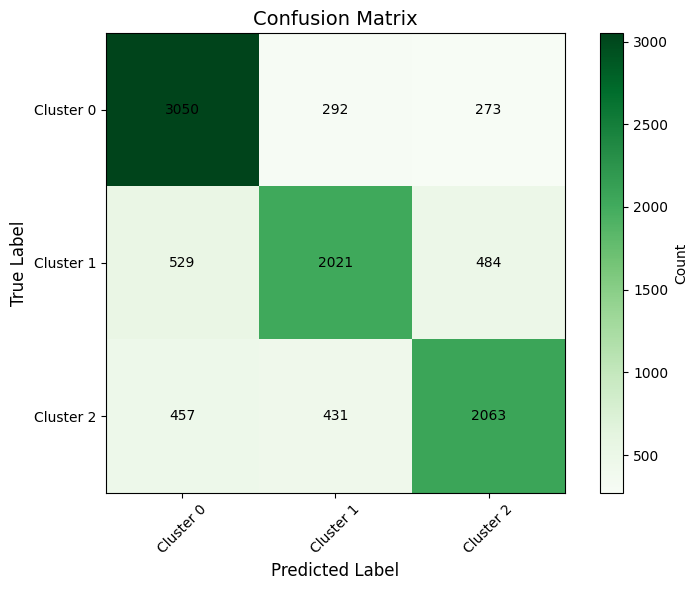

Confusion matrix saved as 'confusion_matrix.png'


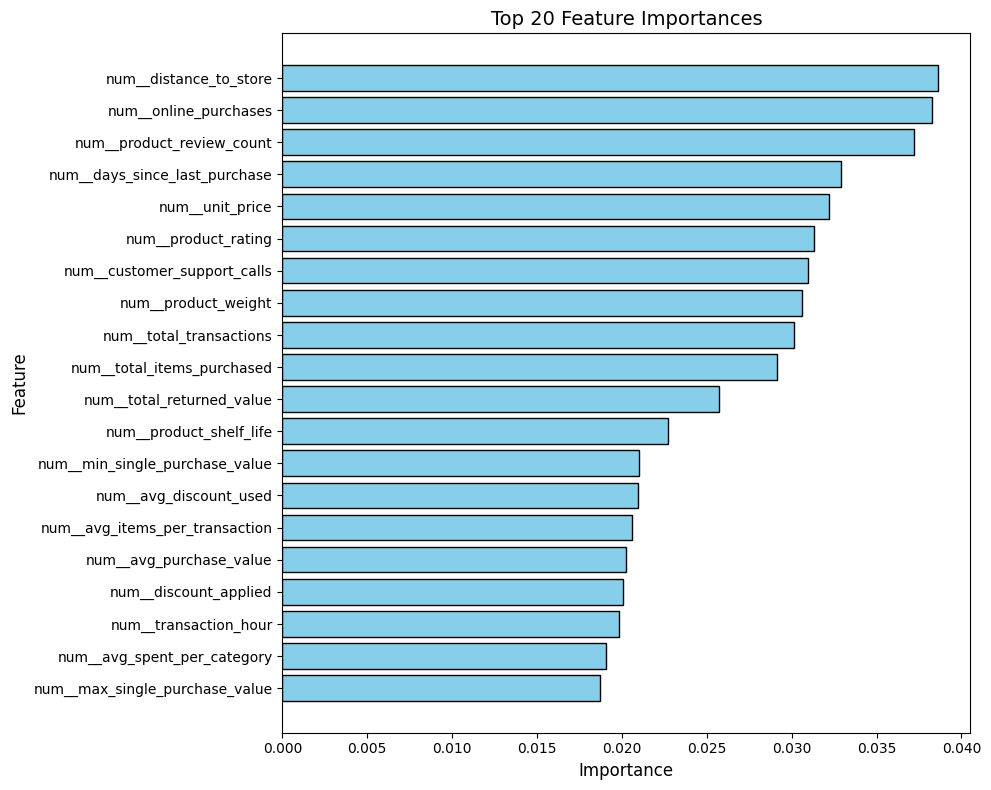

Feature importances plot saved as 'feature_importances_plot.png'


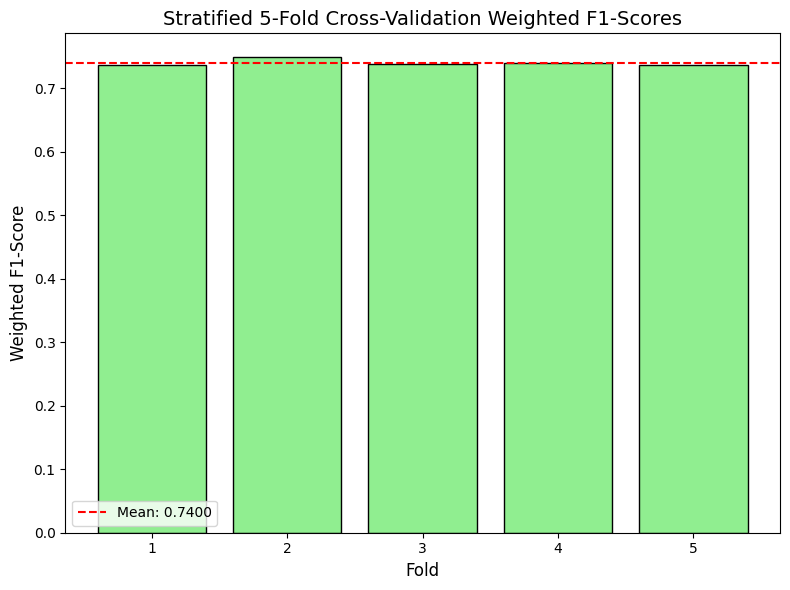

Cross-validation scores plot saved as 'cv_scores.png'


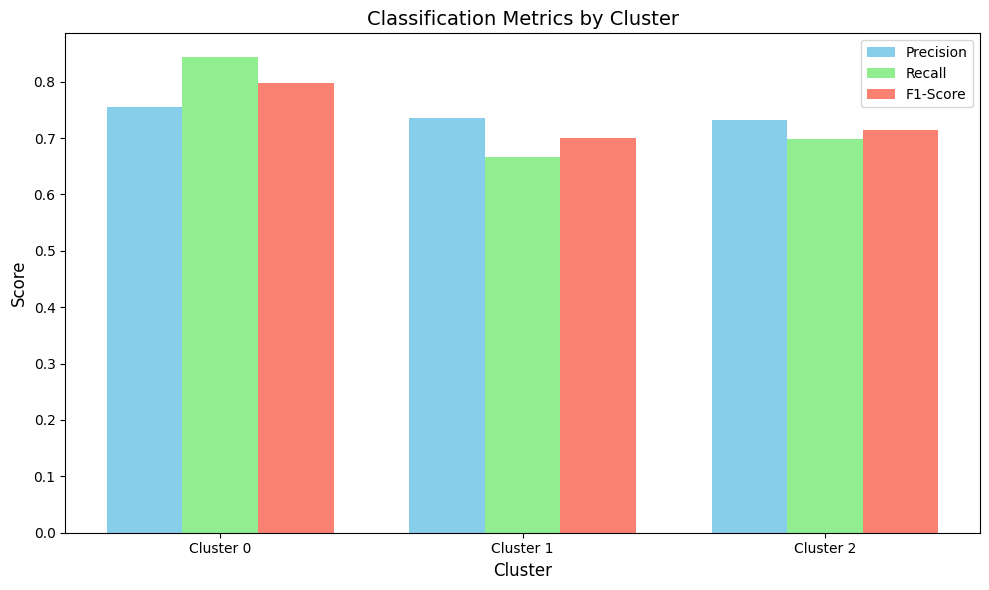

Classification metrics plot saved as 'classification_metrics.png'


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Set a basic Matplotlib style (built-in, no Seaborn dependency)
plt.style.use('default')

# 1. Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Greens')
plt.colorbar(label='Count')
plt.xticks(np.arange(len(target_names)), target_names, rotation=45)
plt.yticks(np.arange(len(target_names)), target_names)
for i in range(len(target_names)):
    for j in range(len(target_names)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()
print("Confusion matrix saved as 'confusion_matrix.png'")

# 2. Top 20 Feature Importances Bar Plot
plt.figure(figsize=(10, 8))
top_20_features = feature_importance_df.head(20)
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue', edgecolor='black')
plt.title('Top 20 Feature Importances', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at top
plt.tight_layout()
plt.savefig('feature_importances_plot.png', dpi=300)
plt.show()
print("Feature importances plot saved as 'feature_importances_plot.png'")

# 3. Cross-Validation Scores Bar Plot
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='lightgreen', edgecolor='black')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.title('Stratified 5-Fold Cross-Validation Weighted F1-Scores', fontsize=14)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Weighted F1-Score', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('cv_scores.png', dpi=300)
plt.show()
print("Cross-validation scores plot saved as 'cv_scores.png'")

# 4. Classification Metrics Bar Plot (Precision, Recall, F1-Score per Class)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
bar_width = 0.25
index = np.arange(len(target_names))

plt.figure(figsize=(10, 6))
plt.bar(index, precision, bar_width, label='Precision', color='skyblue')
plt.bar(index + bar_width, recall, bar_width, label='Recall', color='lightgreen')
plt.bar(index + 2 * bar_width, f1, bar_width, label='F1-Score', color='salmon')
plt.title('Classification Metrics by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(index + bar_width, target_names)
plt.legend()
plt.tight_layout()
plt.savefig('classification_metrics.png', dpi=300)
plt.show()
print("Classification metrics plot saved as 'classification_metrics.png'")

In [ ]:
import pandas as pd
import numpy as np

# Verify y_test and X_test alignment
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")
print(f"Number of NaNs in y_test: {np.isnan(y_test).sum() if np.issubdtype(y_test.dtype, np.number) else 'Non-numeric dtype'}")
print(f"y_test sample (first 5): {y_test[:5]}")

# Recreate proba_df with proper alignment
y_pred_proba = best_model.predict_proba(X_test)
proba_df = pd.DataFrame(y_pred_proba, columns=[f'Proba_Cluster_{i}' for i in unique_clusters])
proba_df['Predicted_Cluster'] = y_pred
proba_df['True_Cluster'] = y_test.reset_index(drop=True)  # Reset index to ensure alignment
proba_df.to_csv('prediction_probabilities_corrected.csv', index=False)
print("Corrected prediction probabilities saved to 'prediction_probabilities_corrected.csv'")
print("\nCorrected Sample Prediction Probabilities (first 5 rows):")
print(proba_df.head())

# Check for NaNs in True_Cluster
print(f"NaNs in True_Cluster: {proba_df['True_Cluster'].isna().sum()}")

Length of X_test: 9600
Length of y_test: 9600
Number of NaNs in y_test: 0
y_test sample (first 5): 23100    2
17362    1
8993     0
19566    1
3798     0
Name: cluster, dtype: int64
Corrected prediction probabilities saved to 'prediction_probabilities_corrected.csv'

Corrected Sample Prediction Probabilities (first 5 rows):
   Proba_Cluster_0  Proba_Cluster_1  Proba_Cluster_2  Predicted_Cluster  \
0         0.232000         0.424000         0.344000                  1   
1         0.395939         0.468061         0.136000                  1   
2         0.527910         0.316045         0.156045                  0   
3         0.092000         0.624000         0.284000                  1   
4         0.400000         0.444000         0.156000                  1   

   True_Cluster  
0             2  
1             1  
2             0  
3             1  
4             0  
NaNs in True_Cluster: 0


In [ ]:
import joblib

# Save the best model (entire pipeline)
joblib.dump(best_model, 'best_random_forest_model.pkl')
print("Best model saved to 'best_random_forest_model.pkl'")

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Preprocessor saved to 'preprocessor.pkl'")

Best model saved to 'best_random_forest_model.pkl'
Preprocessor saved to 'preprocessor.pkl'


Length of X_test: 9600
Length of y_test: 9600
Number of NaNs in y_test: 0
y_test sample (first 5): 23100    2
17362    1
8993     0
19566    1
3798     0
Name: cluster, dtype: int64
Corrected prediction probabilities saved to 'prediction_probabilities_corrected.csv'

Corrected Sample Prediction Probabilities (first 5 rows):
   Proba_Cluster_0  Proba_Cluster_1  Proba_Cluster_2  Predicted_Cluster  \
0         0.232000         0.424000         0.344000                  1   
1         0.395939         0.468061         0.136000                  1   
2         0.527910         0.316045         0.156045                  0   
3         0.092000         0.624000         0.284000                  1   
4         0.400000         0.444000         0.156000                  1   

   True_Cluster  
0             2  
1             1  
2             0  
3             1  
4             0  
NaNs in True_Cluster: 0

Max Probability Distribution:
count    9600.000000
mean        0.487512
std         0.1005

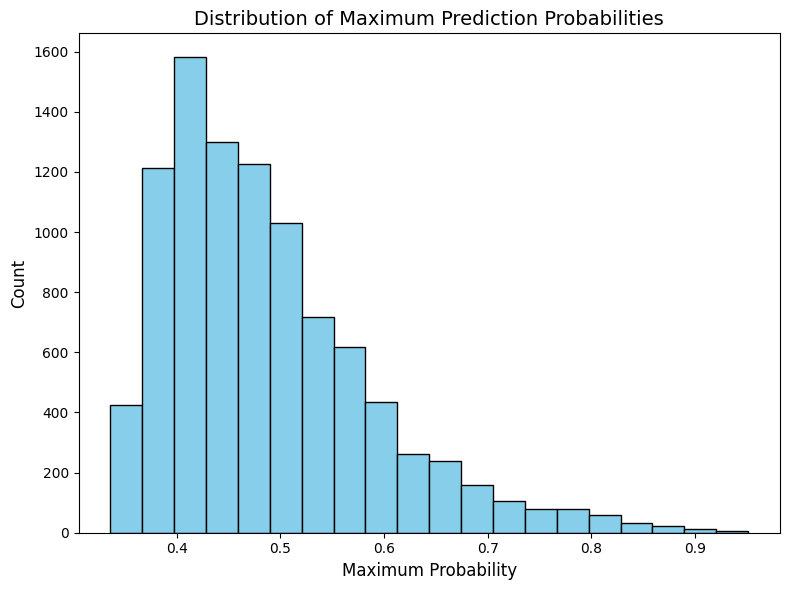

Max probability distribution plot saved to 'max_probability_distribution.png'

Number of misclassified instances: 2466
Sample misclassified instances:
   customer_city  age  True_Cluster  Predicted_Cluster  Proba_Cluster_0  \
0         City C   60             2                  1         0.232000   
4         City B   47             0                  1         0.400000   
7         City D   77             0                  2         0.295761   
10        City D   66             0                  2         0.272000   
15        City C   72             1                  0         0.436000   

    Proba_Cluster_1  Proba_Cluster_2  
0          0.424000         0.344000  
4          0.444000         0.156000  
7          0.160048         0.544191  
10         0.324000         0.404000  
15         0.364000         0.200000  
Misclassified instances saved to 'misclassified_instances.csv'

Cluster 0 Threshold Analysis:
   Threshold  Precision    Recall        F1
0        0.3   0.585345  0

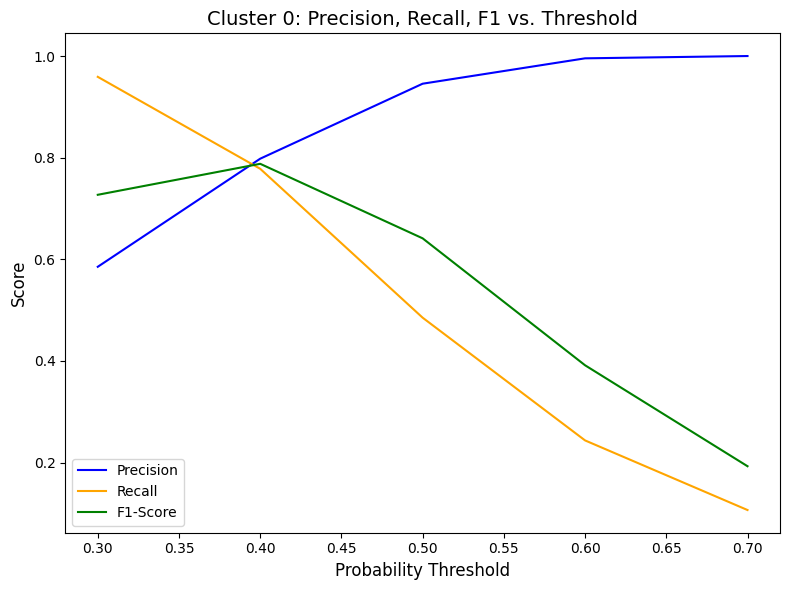

Cluster 0 threshold plot saved to 'cluster_0_thresholds.png'


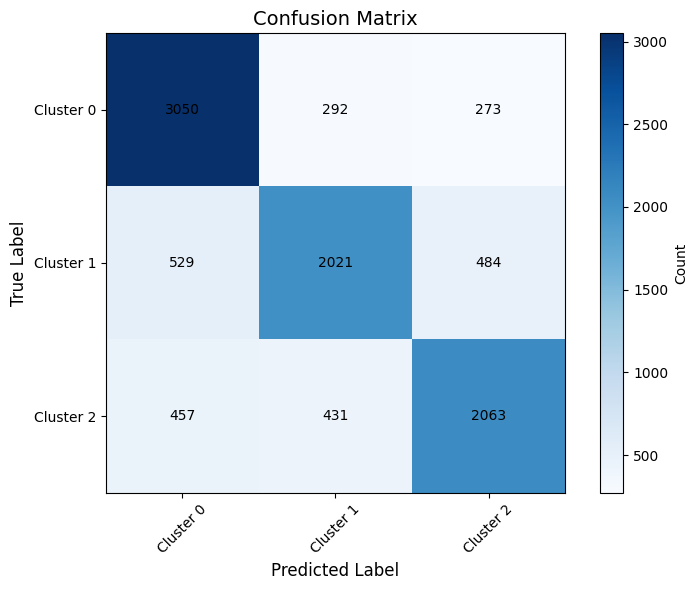

Confusion matrix saved to 'confusion_matrix.png'


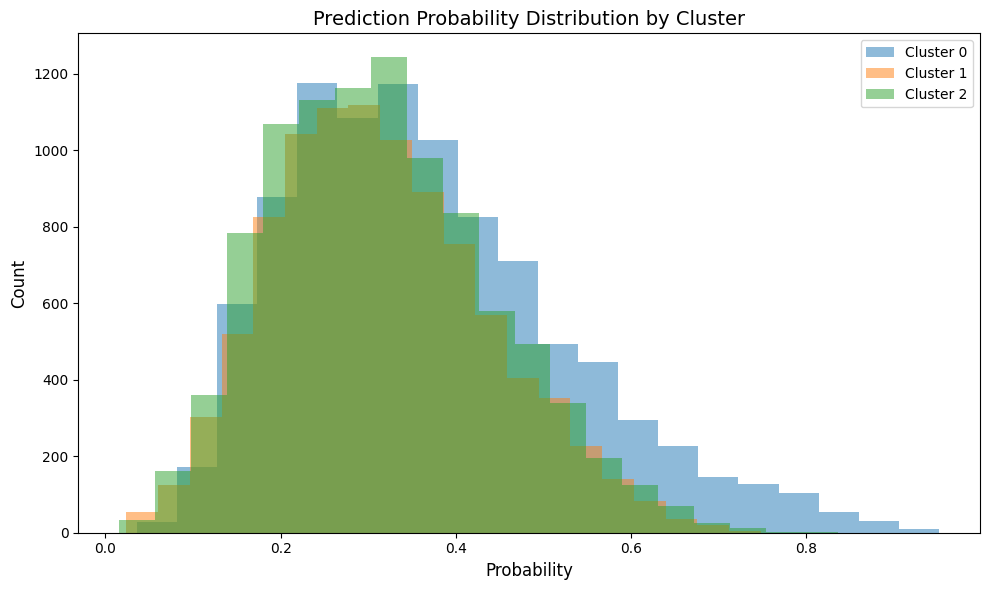

Probability distribution plot saved to 'probability_distribution.png'


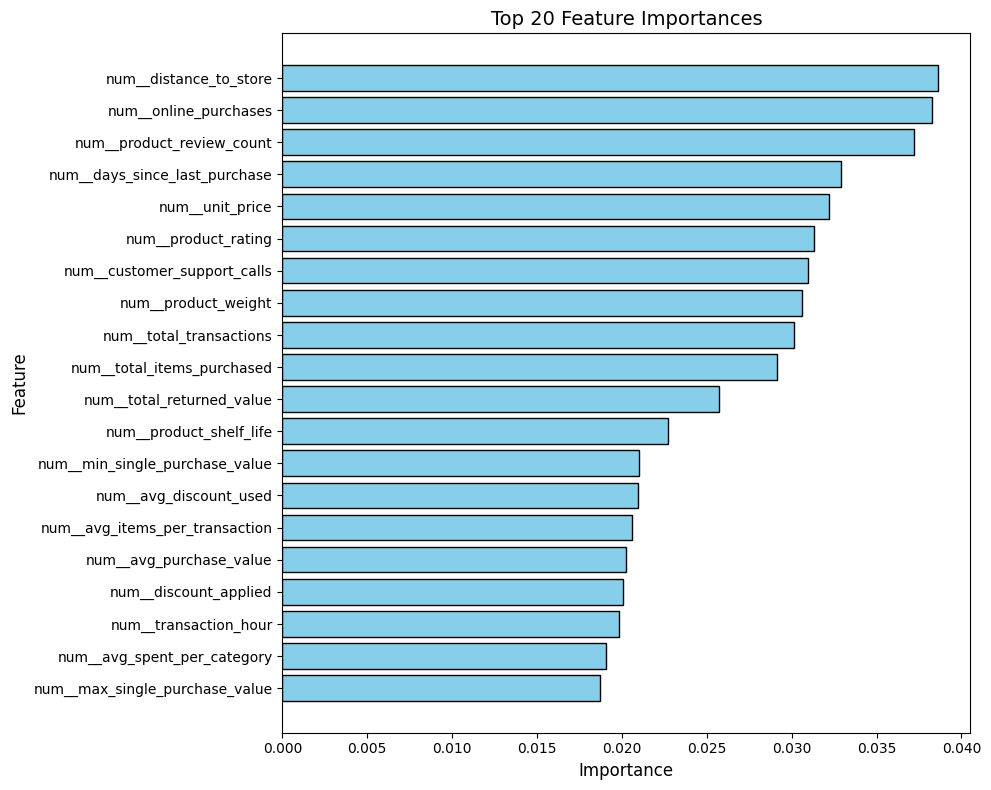

Feature importances plot saved to 'feature_importances_plot.png'
Best model saved to 'best_random_forest_model.pkl'
Preprocessor saved to 'preprocessor.pkl'
Best hyperparameters saved to 'best_hyperparameters.csv'
Cross-validation scores saved to 'cv_scores.csv'


In [ ]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Set default style
plt.style.use('default')

# Fix NaN issue in proba_df
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")
print(f"Number of NaNs in y_test: {np.isnan(y_test).sum() if np.issubdtype(y_test.dtype, np.number) else 'Non-numeric dtype'}")
print(f"y_test sample (first 5): {y_test[:5]}")
y_pred_proba = best_model.predict_proba(X_test)
proba_df = pd.DataFrame(y_pred_proba, columns=[f'Proba_Cluster_{i}' for i in unique_clusters])
proba_df['Predicted_Cluster'] = y_pred
proba_df['True_Cluster'] = y_test.reset_index(drop=True)
proba_df.to_csv('prediction_probabilities_corrected.csv', index=False)
print("Corrected prediction probabilities saved to 'prediction_probabilities_corrected.csv'")
print("\nCorrected Sample Prediction Probabilities (first 5 rows):")
print(proba_df.head())
print(f"NaNs in True_Cluster: {proba_df['True_Cluster'].isna().sum()}")

# Prediction Confidence Analysis
proba_df['Max_Probability'] = proba_df[[f'Proba_Cluster_{i}' for i in unique_clusters]].max(axis=1)
print("\nMax Probability Distribution:")
print(proba_df['Max_Probability'].describe())
low_confidence = proba_df[proba_df['Max_Probability'] < 0.5]
print(f"\nNumber of low-confidence predictions (max prob < 0.5): {len(low_confidence)}")
print("Sample low-confidence predictions:")
print(low_confidence.head())
proba_df.to_csv('prediction_probabilities_with_confidence.csv', index=False)
print("Prediction probabilities with max confidence saved to 'prediction_probabilities_with_confidence.csv'")
plt.figure(figsize=(8, 6))
plt.hist(proba_df['Max_Probability'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Maximum Prediction Probabilities', fontsize=14)
plt.xlabel('Maximum Probability', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.savefig('max_probability_distribution.png', dpi=300)
plt.show()
print("Max probability distribution plot saved to 'max_probability_distribution.png'")

# Misclassification Analysis
test_indices = np.arange(len(X_test))
test_data_subset = data.iloc[test_indices][['customer_city', 'age']].copy()
test_data_subset['True_Cluster'] = y_test.reset_index(drop=True)
test_data_subset['Predicted_Cluster'] = y_pred
misclassified = test_data_subset[test_data_subset['True_Cluster'] != test_data_subset['Predicted_Cluster']]
misclassified = misclassified.join(proba_df[[f'Proba_Cluster_{i}' for i in unique_clusters]])
misclassified.to_csv('misclassified_instances.csv', index=False)
print(f"\nNumber of misclassified instances: {len(misclassified)}")
print("Sample misclassified instances:")
print(misclassified.head())
print("Misclassified instances saved to 'misclassified_instances.csv'")

# Threshold Tuning for Cluster 0
thresholds = np.arange(0.3, 0.8, 0.1)
metrics = []
for thresh in thresholds:
    cluster_0_pred = (proba_df['Proba_Cluster_0'] >= thresh).astype(int)
    true_cluster_0 = (proba_df['True_Cluster'] == 0).astype(int)
    precision = precision_score(true_cluster_0, cluster_0_pred)
    recall = recall_score(true_cluster_0, cluster_0_pred)
    f1 = f1_score(true_cluster_0, cluster_0_pred)
    metrics.append({'Threshold': thresh, 'Precision': precision, 'Recall': recall, 'F1': f1})
threshold_df = pd.DataFrame(metrics)
threshold_df.to_csv('cluster_0_thresholds.csv', index=False)
print("\nCluster 0 Threshold Analysis:")
print(threshold_df)
print("Cluster 0 threshold metrics saved to 'cluster_0_thresholds.csv'")
plt.figure(figsize=(8, 6))
plt.plot(threshold_df['Threshold'], threshold_df['Precision'], label='Precision', color='blue')
plt.plot(threshold_df['Threshold'], threshold_df['Recall'], label='Recall', color='orange')
plt.plot(threshold_df['Threshold'], threshold_df['F1'], label='F1-Score', color='green')
plt.title('Cluster 0: Precision, Recall, F1 vs. Threshold', fontsize=14)
plt.xlabel('Probability Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('cluster_0_thresholds.png', dpi=300)
plt.show()
print("Cluster 0 threshold plot saved to 'cluster_0_thresholds.png'")

# Visualizations
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar(label='Count')
plt.xticks(np.arange(len(target_names)), target_names, rotation=45)
plt.yticks(np.arange(len(target_names)), target_names)
for i in range(len(target_names)):
    for j in range(len(target_names)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()
print("Confusion matrix saved to 'confusion_matrix.png'")

plt.figure(figsize=(10, 6))
for i in unique_clusters:
    plt.hist(proba_df[f'Proba_Cluster_{i}'], bins=20, alpha=0.5, label=f'Cluster {i}')
plt.title('Prediction Probability Distribution by Cluster', fontsize=14)
plt.xlabel('Probability', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('probability_distribution.png', dpi=300)
plt.show()
print("Probability distribution plot saved to 'probability_distribution.png'")

plt.figure(figsize=(10, 8))
top_20_features = feature_importance_df.head(20)
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue', edgecolor='black')
plt.title('Top 20 Feature Importances', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importances_plot.png', dpi=300)
plt.show()
print("Feature importances plot saved to 'feature_importances_plot.png'")

# Save model and artifacts
joblib.dump(best_model, 'best_random_forest_model.pkl')
print("Best model saved to 'best_random_forest_model.pkl'")
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Preprocessor saved to 'preprocessor.pkl'")
pd.DataFrame([best_params]).to_csv('best_hyperparameters.csv', index=False)
print("Best hyperparameters saved to 'best_hyperparameters.csv'")
pd.DataFrame({'Fold': range(1, len(cv_scores) + 1), 'Weighted_F1': cv_scores}).to_csv('cv_scores.csv', index=False)
print("Cross-validation scores saved to 'cv_scores.csv'")

In [ ]:
import joblib
import pandas as pd

# Load the model and preprocessor
best_model = joblib.load('best_random_forest_model.pkl')
preprocessor = joblib.load('preprocessor.pkl')

# Example: Make predictions on new data
new_data = pd.read_csv('new_data.csv')  # Replace with your new data
X_new = new_data[selected_features]
X_new_transformed = preprocessor.transform(X_new)
predictions = best_model.predict(X_new_transformed)
proba = best_model.predict_proba(X_new_transformed)

# Save predictions
pd.DataFrame({
    'Predicted_Cluster': predictions,
    **{f'Proba_Cluster_{i}': proba[:, i] for i in range(proba.shape[1])}
}).to_csv('new_predictions.csv', index=False)
print("New predictions saved to 'new_predictions.csv'")

## Random Forest - With Balancing - Selected Features

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SKPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter
import pandas as pd
import numpy as np

# Verify train_data and test_data exist from previous steps
if 'train_data' not in globals() or 'test_data' not in globals():
    raise ValueError("train_data or test_data not found! Ensure previous steps are executed.")

# Define the attributes as specified
selected_features = [
    # Categorical attributes
    'last_purchase_month', 'promotion_end_month', 'product_manufacture_month',
    'month_of_year', 'product_expiry_date_year', 'product_manufacture_year',
    'transaction_year', 'product_expiry_date_month', 'transaction_month',
    'high_value_purchase', 'week_of_year', 'promotion_start_month', 'day_of_week',
    'purchase_frequency', 'customer_city', 'gender', 'weekend', 'store_state',
    'email_subscriptions', 'store_location', 'high_value_quantity',
    # Numeric attributes
    'customer_support_calls', 'product_review_count', 'days_since_last_purchase',
    'online_purchases', 'distance_to_store', 'product_rating', 'total_transactions',
    'product_weight', 'total_items_purchased', 'unit_price', 'total_returned_value',
    'membership_years', 'discount_applied', 'avg_discount_used', 'product_shelf_life',
    'total_returned_items', 'transaction_hour', 'min_single_purchase_value',
    'number_of_children', 'product_stock', 'avg_purchase_value',
    'avg_items_per_transaction', 'website_visits', 'age', 'max_single_purchase_value',
    'avg_spent_per_category', 'total_discounts_received', 'product_return_rate',
    'avg_transaction_value', 'in_store_purchases'
]

# Filter features that exist in train_data
selected_features = [col for col in selected_features if col in train_data.columns]
print("Initial selected features:", selected_features)

# Combine train_data and test_data for balancing
data = pd.concat([train_data, test_data], axis=0)
X = data[selected_features]
y = data['cluster']

# Print class distribution before balancing
print("Class Distribution Before Balancing:", Counter(y))

# Identify categorical and numeric columns among selected features
categorical_cols = [col for col in selected_features if col in ['last_purchase_month', 'promotion_end_month', 'product_manufacture_month', 'month_of_year', 'product_expiry_date_year',
                                                                'product_manufacture_year', 'transaction_year', 'product_expiry_date_month', 'transaction_month', 'high_value_purchase',
                                                                'week_of_year', 'promotion_start_month', 'day_of_week', 'purchase_frequency', 'customer_city', 'gender', 'weekend', 'store_state',
                                                                'email_subscriptions', 'store_location', 'high_value_quantity']]
numeric_cols = [col for col in selected_features if col not in categorical_cols]

# Preprocessing pipeline for encoding and scaling
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols)
])

# Preprocess the data before balancing to avoid string-to-float issues
X_transformed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

# Define balancing strategy: target 2,000 samples per cluster
sampling_strategy_under = {1: 10000}
sampling_strategy_over = {0: 10000, 2: 10000}

# Create a pipeline for undersampling and oversampling
balancing_pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=42)),
    ('oversample', SMOTE(sampling_strategy=sampling_strategy_over, random_state=42))
])

# Apply balancing
X_resampled, y_resampled = balancing_pipeline.fit_resample(X_transformed, y)

# Check dataset distribution after balancing
print("After Balancing:", Counter(y_resampled))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Initialize RFECV with a Random Forest base estimator
base_model = RandomForestClassifier(random_state=42, n_estimators=50)  # Reduced n_estimators for speed
rfecv = RFECV(estimator=base_model, step=1, cv=3, scoring='accuracy', n_jobs=-1)
rfecv.fit(X_train, y_train)

# Get selected features from transformed space
selected_mask = rfecv.support_
selected_transformed_features = feature_names[selected_mask].tolist()
print(f"Number of Features Selected by RFECV: {len(selected_transformed_features)}")
print(f"Selected Transformed Features: {selected_transformed_features}")

# Map transformed features back to original features
original_selected_features = []
for transformed_feature in selected_transformed_features:
    if transformed_feature.startswith('num__'):
        original_feature = transformed_feature.replace('num__', '')
    elif transformed_feature.startswith('cat__'):
        original_feature = transformed_feature.replace('cat__', '').split('_')[0]
    else:
        original_feature = transformed_feature
    if original_feature in selected_features and original_feature not in original_selected_features:
        original_selected_features.append(original_feature)

print(f"Selected Original Features: {original_selected_features}")

# Since X_train and X_test are already transformed, select the corresponding transformed feature indices
selected_indices = [i for i, name in enumerate(feature_names) if name in selected_transformed_features]
X_train_rfe = X_train[:, selected_indices]
X_test_rfe = X_test[:, selected_indices]

# Create pipeline with Random Forest (no preprocessing needed since data is pre-transformed)
pipeline_rfe = SKPipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini']
}

grid_search = GridSearchCV(pipeline_rfe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_rfe, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train Random Forest with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_rfe, y_train)

# Get feature importances from the final model
feature_importances = pd.DataFrame({
    'Feature': selected_transformed_features,
    'Importance': best_model.named_steps['classifier'].feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature Importances from Final Model:")
print(feature_importances)

# Predictions on test set
y_pred = best_model.predict(X_test_rfe)

# Get unique cluster labels for classification report
unique_clusters = sorted(np.unique(y_train))
target_names = [f'Cluster {i}' for i in unique_clusters]

# Classification Report and Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Accuracy, Recall, Precision
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate Specificity for each cluster
def calculate_specificity(class_idx):
    tn = cm.sum() - cm[:, class_idx].sum() - cm[class_idx, :].sum() + cm[class_idx, class_idx]
    fp = cm[:, class_idx].sum() - cm[class_idx, class_idx]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Calculate specificity for each cluster
specificity_scores = {f'Cluster {i}': calculate_specificity(idx) for idx, i in enumerate(unique_clusters)}

# Print metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
for cluster, spec in specificity_scores.items():
    print(f"Specificity for {cluster}: {spec:.4f}")

print("-----------------------------------------------")

# --- Cross-Validation on Full Dataset ---
# Combine train and test data for cross-validation
X_full = np.vstack([X_train_rfe, X_test_rfe])
y_full = np.concatenate([y_train, y_test])

# Perform 5-fold cross-validation using the best model
cv_scores = cross_val_score(best_model, X_full, y_full, cv=5, scoring='accuracy', n_jobs=-1)
print(f"\nCross-Validation Results (5-fold):")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print(f"Individual Fold Scores: {cv_scores}")

Initial selected features: ['last_purchase_month', 'promotion_end_month', 'product_manufacture_month', 'month_of_year', 'product_expiry_date_year', 'product_manufacture_year', 'transaction_year', 'product_expiry_date_month', 'transaction_month', 'high_value_purchase', 'week_of_year', 'promotion_start_month', 'day_of_week', 'purchase_frequency', 'customer_city', 'gender', 'weekend', 'store_state', 'email_subscriptions', 'store_location', 'high_value_quantity', 'customer_support_calls', 'product_review_count', 'days_since_last_purchase', 'online_purchases', 'distance_to_store', 'product_rating', 'total_transactions', 'product_weight', 'total_items_purchased', 'unit_price', 'total_returned_value', 'membership_years', 'discount_applied', 'avg_discount_used', 'product_shelf_life', 'total_returned_items', 'transaction_hour', 'min_single_purchase_value', 'number_of_children', 'product_stock', 'avg_purchase_value', 'avg_items_per_transaction', 'website_visits', 'age', 'max_single_purchase_valu